In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the author's parameters, but vary in the number of filters, number of layers, and increase the filter length to 30+ in order to try and capture long-range interactions

In [171]:
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=30, filter_len=50, dropout1=0,
#                     dropout2=0,dropout3=0.2)

In [ ]:
# e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test['rl'], e_test['pred'])
# print 'r-squared = ', r
# print 'r-squared of original model = 0.9338...'

In [ ]:
#model.save('./saved_models/long_range_model_50bp.hdf5')

### How important is the size of the model? 
Does reducing its size only lose a small amount of r-squared, like with the 8-bp window CNN? That might seem to indicate that the total information content available is limited, but maybe that's not the correct interpretation...?

In [5]:
# np.random.seed(1337)
# small_model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=5, filter_len=50, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 37s 141us/step - loss: 0.4924
Epoch 2/3
260000/260000 [==============================] - 36s 139us/step - loss: 0.2403
Epoch 3/3
260000/260000 [==============================] - 35s 135us/step - loss: 0.1724


In [3]:
# e_test_small = test_data(df=e_test.copy(), model=small_model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test_small['rl'], e_test_small['pred'])
# print 'r-squared = ', r

In [10]:
#model.save('./saved_models/long_range_model_50bp_small.hdf5')

## Visualizing Model Results

In [4]:
model = keras.models.load_model('./saved_models/long_range_model_50bp.hdf5')

W0822 12:57:35.674617 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 12:57:35.701009 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 12:57:35.827963 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 12:57:35.833188 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0822 12:57:35.854979 4690392512 deprecat

In [5]:
e_test = test_data(df=e_test.copy(), model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9314214048210052


In [6]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
print "Number of utrs with ATG:", len(atg)
print "Number of utrs without ATG:", len(n_atg)

Number of utrs with ATG: 13986
Number of utrs without ATG: 6014


/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


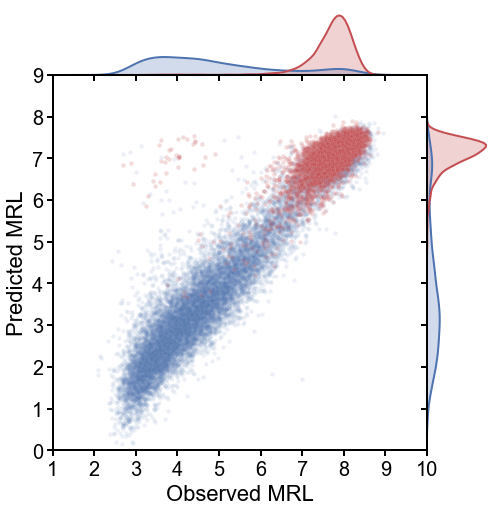

In [6]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

## Are the Off-Diagonal Sequences the Same?

(As compared to the authors' model, that is)

In [7]:
off_diagonal = e_test[(e_test['rl']<4.6)&(e_test['pred']>5.4)].sort_values(by='utr')
off_diagonal = off_diagonal.drop(columns=['Unnamed: 0'])
off_diagonal = off_diagonal.rename(columns={'pred':'pred_50bp'})
len(off_diagonal)

50

In [8]:
auth_off_diagonal = pd.read_csv('../off_diagonal_utrs.csv').sort_values(by='utr')
auth_off_diagonal = auth_off_diagonal.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
auth_off_diagonal = auth_off_diagonal.rename(columns={'pred':'pred_auth'})
len(auth_off_diagonal)

48

In [9]:
rnn_off_diagonal = pd.read_csv('../off_diagonal_rnn_utrs.csv').sort_values(by='utr')
rnn_off_diagonal = rnn_off_diagonal.drop(columns=['Unnamed: 0'])
rnn_off_diagonal = rnn_off_diagonal.rename(columns={'pred':'pred_rnn'})
len(rnn_off_diagonal)

50

In [10]:
set_50bp = set(off_diagonal['utr'].values)
set_auth = set(auth_off_diagonal['utr'].values)
set_rnn = set(rnn_off_diagonal['utr'].values)

In [11]:
set_shared = set_50bp.intersection(set_auth).intersection(set_rnn)
len(set_shared)

45

In [12]:
z = off_diagonal[off_diagonal['utr'].isin(set_shared)].set_index('utr')
w = auth_off_diagonal[auth_off_diagonal['utr'].isin(set_shared)].set_index('utr')
u = rnn_off_diagonal[rnn_off_diagonal['utr'].isin(set_shared)].set_index('utr')
shared_off_diagonals = pd.concat([z,w['pred_auth'],u['pred_rnn']],axis=1)
shared_off_diagonals = shared_off_diagonals.reset_index()
shared_off_diagonals.head(3)

,utr,0,1,2,3,4,5,6,7,8,...,r8,r9,r10,r11,r12,r13,rl,pred_50bp,pred_auth,pred_rnn
0,AAACGCGGTGGATCACGGCCAGCTAGAGGGCGAAGGCGTCCTTCCACCAG,0.000031,0.000027,0.000013,0.000009,0.000007,0.000004,0.000003,0.000003,0.000004,...,0.030310,0.017522,0.033050,0.033050,0.026678,0.034121,3.237970,5.849938,5.670214,6.179446
1,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,0.000004,...,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,6.207780,5.623970,6.539258
2,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,0.000034,0.000036,0.000025,0.000013,0.000009,0.000009,0.000005,0.000006,0.000005,...,0.030538,0.026672,0.043827,0.043827,0.042533,0.051309,4.065457,5.787129,5.995093,6.047128
3,ATCAGGGCTAGATTAATACGTAGCTCAGACAGTTATATTGAATCACCTGA,0.000017,0.000019,0.000017,0.000009,0.000005,0.000005,0.000003,0.000003,0.000005,...,0.046429,0.033113,0.043098,0.043098,0.048786,0.057706,4.411140,7.409012,7.143446,7.101318
4,CAATAGGCAGGTGCGCGCTACGCGCGGGATTCCTAGACCACTCGGTCAAT,0.000035,0.000026,0.000013,0.000007,0.000005,0.000004,0.000003,0.000003,0.000002,...,0.014933,0.025135,0.019118,0.019118,0.024517,0.026212,2.677383,6.840362,6.863350,6.812460
5,CACCGAGTCTTGCGGCCTAAATCCGTAGGGGTCTGGGTCCACGATTGTCC,0.000036,0.000031,0.000018,0.000009,0.000006,0.000007,0.000004,0.000004,0.000004,...,0.025882,0.026299,0.035648,0.035648,0.031976,0.037537,3.450179,6.618365,6.479451,6.480992
6,CACTCGTATACATATAACACGCAAATTGCTGTATCCATAAACAACGCAGT,0.000018,0.000019,0.000014,0.000007,0.000004,0.000004,0.000003,0.000004,0.000003,...,0.034665,0.044169,0.042853,0.042853,0.048468,0.039709,4.127045,7.523306,7.445688,7.339086
7,CAGCAGCGAGTGTCTGGCCGCGTTCAGGTAAAGGCGTAAACAACGCTCAG,0.000021,0.000022,0.000014,0.000007,0.000004,0.000005,0.000004,0.000004,0.000003,...,0.026501,0.031449,0.034996,0.034996,0.037160,0.046735,3.807885,6.988488,6.925332,6.839564
8,CAGTACCCGACGTGGGAAATTAACATACCATTGGACCCTTCCCACGTCAA,0.000027,0.000025,0.000015,0.000008,0.000006,0.000005,0.000004,0.000003,0.000003,...,0.029426,0.032772,0.041309,0.041309,0.038650,0.034648,3.701647,6.905163,6.924004,6.824212
9,CAGTCGGTAGATAAAGACCACACAGGCACCTGTCACCCGCTGCGTACCTC,0.000021,0.000023,0.000016,0.000007,0.000005,0.000005,0.000004,0.000004,0.000004,...,0.035963,0.038392,0.046187,0.046187,0.035746,0.039692,4.020205,6.783804,6.855105,6.806893


In [13]:
shared_off_diagonals.to_csv('../off_diagonal_utrs_shared.csv')